# Learning, Fraud Detection - Tuned

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

%matplotlib inline

import altair as alt
alt.renderers.enable('notebook')
%env JOBLIB_TEMP_FOLDER=/tmp

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

from altair.vega import v5
from IPython.display import HTML

env: JOBLIB_TEMP_FOLDER=/tmp


In [61]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [62]:
train_identity = pd.read_csv('data/train_identity.csv')
print("Train identity:{}".format(train_identity.shape))
train_transaction = pd.read_csv('data/train_transaction.csv')
print("Train transaction:{}".format(train_transaction.shape))

Train identity:(144233, 41)
Train transaction:(590540, 394)


In [63]:
train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)

Memory usage of dataframe is 45.12 MB --> 25.86 MB (Decreased by 42.7%)
Memory usage of dataframe is 1775.15 MB --> 542.35 MB (Decreased by 69.4%)


In [64]:
# Join Transaction and Identity dataframes
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Feature Engineering

In [65]:
# Delete identity and transaction dataframes from memory
del train_identity, train_transaction
gc.collect()

2682

In [66]:
# http://localhost:8888/notebooks/IEEE-CIS%20Fraud%20Detection%20_%20EDA.ipynb
import datetime

START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train['Date'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train['_ymd'] = train['Date'].dt.year.astype(str) + '-' + train['Date'].dt.month.astype(str) + '-' + train['Date'].dt.day.astype(str)
train['_year_month'] = train['Date'].dt.year.astype(str) + '-' + train['Date'].dt.month.astype(str)
train['_weekday'] = train['Date'].dt.dayofweek
train['_hour'] = train['Date'].dt.hour
train['_day'] = train['Date'].dt.day


In [67]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# id_30 OS
train.loc[train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train.loc[train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train.loc[train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
train.loc[train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
train['id_30'].fillna("NAN", inplace=True)

In [68]:
train['id_30'].value_counts()

NAN        512975
Windows     36739
iOS         19782
Mac         13580
Android      6303
Linux        1136
other          15
func           10
Name: id_30, dtype: int64

In [69]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# id_31 Browser
train.loc[train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
train.loc[train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
train.loc[train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
train.loc[train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
train.loc[train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
train.loc[train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
train.loc[train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
train['id_31'].fillna("NAN", inplace=True)
train.loc[train.id_31.isin(train.id_31.value_counts()[train.id_31.value_counts() < 200].index), 'id_31'] = "Others"
train['id_31'].value_counts()

NAN        450258
Chrome      76059
Safari      37281
IE          10018
Firefox      7012
Edge         6401
Samsung      2044
Others        706
Opera         449
other         312
Name: id_31, dtype: int64

In [70]:
train.drop('TransactionID', axis=1, inplace=True)
train.drop('TransactionDT', axis=1, inplace=True)
train.drop('_ymd', axis=1, inplace=True)
train.drop('_year_month', axis=1, inplace=True)
train.drop('Date', axis=1, inplace=True)

In [71]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 
            'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 
            'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4',
            'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2','P_emaildomain',
            'R_emaildomain', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 
            'M8', 'M9']
for col in cat_cols:
    if col in train.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

In [72]:
y = train['isFraud']
X = train.drop('isFraud', axis=1)

del train
gc.collect()

109

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)
X_train.head()

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,_weekday,_hour,_day
5307,59.0000,4,9638,233,42,4,108,2,166,65,...,4,2,2,2,2,2,1742,5,0,2
191582,23.3750,0,8788,195,73,4,108,1,332,74,...,4,0,0,1,0,0,1742,3,18,18
260168,35.9375,4,2250,167,42,4,58,2,282,65,...,4,2,2,2,2,2,1742,5,2,10
18516,100.0000,2,10436,482,42,4,108,1,17,65,...,3,1,0,1,0,0,1598,1,18,5
47538,75.0000,1,5226,413,42,2,2,1,173,65,...,3,1,0,1,1,1,1297,2,0,13


In [75]:
def show_scores(y_test, y_pred):
    tp_count = 0
    fp_count = 0
    tn_count = 0
    fn_count = 0

    y_t = np.array(y_test)
    count = y_t.size

    for i in range(y_t.size):
        if y_t[i] == 1 and y_pred[i] == 1:
            tp_count += 1
        elif y_t[i] == 1 and y_pred[i] == 0:
            fn_count += 1
        elif y_t[i] == 0 and y_pred[i] == 1:
            fp_count += 1
        elif y_t[i] == 0 and y_pred[i] == 0:
            tn_count += 1

    print ("true positive {0}, false positive: {1}, false negative: {2}, true negative: {3}"
          .format(tp_count, fp_count, fn_count, tn_count))

    precision = tp_count / (tp_count + fp_count)
    recall = tp_count / (tp_count + fn_count)

    print ("Precision: {0}, Recall: {1}".format(precision, recall))

    f1 = 2 * ((precision * recall) / (precision + recall))

    print ("F1 score: {}".format(f1))

In [77]:
%%time

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Create parameters to search
gridParams = {
    'learning_rate': [0.005, 0.01],
    'metric': ['auc'],
    'n_estimators': [3000],
    'num_threads': [-1],
    'num_leaves': [32, 256, 512],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'verbose': [1],
    'random_state' : [42],
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    'bagging_fraction': [0.75, 0.85, 1.0],
    'feature_fraction': [0.75, 0.85, 1.0]
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = -1,
          max_bin = 512,
          subsample_for_bin = 200,
          subsample = 1,
          subsample_freq = 1,
          min_split_gain = 0.5,
          min_child_weight = 1,
          min_child_samples = 5,
          scale_pos_weight = 1)

# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)


/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [ ]:

# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

clf = lgb.LGBMClassifier(**params, n_estimators=3000)
clf.fit(X_train, y_train)

oof_preds = clf.predict_proba(X_train, num_iteration=clf.best_iteration_)[:,1]
sub_preds = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:,1]

y_preds = clf.predict(X_test, num_iteration=clf.best_iteration_)
show_scores(y_test, y_preds)

AUC: 0.9748879492609878


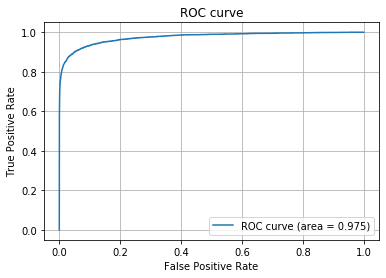

In [59]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, sub_preds)
auc = metrics.auc(fpr, tpr)

print("AUC: {}".format(auc))
plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [323]:
sub_preds.size
y_preds = [0 if pred < 0.01 else 1 for pred in sub_preds]
y_preds
show_scores(y_test, y_preds)

true positive 3823, false positive: 5466, false negative: 419, true negative: 108400
Precision: 0.4115620626547529, Recall: 0.9012258368694013
F1 score: 0.5650727958022319


In [ ]:
# Plot feature importance
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 50:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()